# AML - VOC 2012

## Imports and utility

In [1]:
!pip install pympler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 13.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pympler import asizeof

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
RANDOM_STATE = 17
N_IMAGES_TO_SHOW = 10
N_CLASSES = 20
IMG_SIZE = (128, 128)

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
ROOT_DIR = '/content/drive/MyDrive/'
#BASE_DIR = ROOT_DIR + 'AML/project/dataset/compressed/'
BASE_DIR = ROOT_DIR + 'project/dataset/compressed/'

BASE_DIR

'/content/drive/MyDrive/project/dataset/compressed/'

In [6]:
TRAIN_PATH = BASE_DIR + 'train.npz'
VALIDATION_PATH = BASE_DIR + 'validation.npz'
TEST_PATH = BASE_DIR + 'test.npz'

TRAIN_PATH, VALIDATION_PATH, TEST_PATH

('/content/drive/MyDrive/project/dataset/compressed/train.npz',
 '/content/drive/MyDrive/project/dataset/compressed/validation.npz',
 '/content/drive/MyDrive/project/dataset/compressed/test.npz')

In [7]:
def plot_history(history) -> None:
    metrics = list(history.history.keys())

    n_metrics = len([m for m in metrics if not m.startswith('val_')])
    n_cols = 2
    n_rows = (n_metrics + 1) // 2  # Arrotonda per eccesso

    fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.tight_layout(pad=3.0)

    if n_rows > 1:
        axis = axis.flatten()

    plot_index = 0

    base_metrics = [m for m in metrics if not m.startswith('val_')]

    for metric in base_metrics:
        val_metric = f'val_{metric}'

        if metric not in history.history:
            continue

        train_data = history.history[metric]
        val_data = history.history[val_metric] if val_metric in history.history else None

        if n_rows > 1:
            current_axis = axis[plot_index]
        else:
            current_axis = axis[plot_index] if n_cols > 1 else axis

        current_axis.set_title(f'{metric.capitalize()}')
        current_axis.set_xlabel('Epochs')
        current_axis.set_ylabel(metric.capitalize())

        current_axis.plot(train_data, label=f'Training {metric.capitalize()}')
        if val_data is not None:
            current_axis.plot(val_data, label=f'Validation {metric.capitalize()}')

        current_axis.legend()

        plot_index += 1

    while plot_index < len(axis):
        fig.delaxes(axis[plot_index])
        plot_index += 1

    plt.show()

In [8]:
CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

classes_map = {c: i for i, c in enumerate(CLASSES)}
classes_map

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [9]:
def vector_encoding(labels:list[int], num_classes:int):
    class_vector = np.zeros(num_classes)
    for label in labels:
      class_vector[classes_map[label]] = 1
    return class_vector

In [10]:
def preprocess_images(images: np.ndarray, resize=IMG_SIZE):
    images /= 255.0
    resized_images = []

    for i in range(images.shape[0]):
        resized_image = tf.image.resize(images[i], resize).numpy()
        resized_images.append(resized_image)

    resized_images = np.array(resized_images)
    del images

    return resized_images

## Preprocessing

### Training set

In [11]:
train_data = np.load(TRAIN_PATH, allow_pickle=True)
train_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/train.npz' with keys: images, labels

In [12]:
train_images = train_data['images']
train_images.shape

(9232, 227, 227, 3)

In [13]:
print(f'Size of train images before preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images before preprocessing: 5.316537722945213 GB


Image preprocessing:

In [14]:
train_images = preprocess_images(train_images)
train_images.shape

(9232, 128, 128, 3)

In [15]:
print(f'Size of train images after preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images after preprocessing: 1.6904298514127731 GB


Labels encoding:

In [16]:
train_labels = train_data['labels']
train_labels.shape

(9232,)

In [17]:
print(f'Size of train labels before encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels before encoding: 0.0706024169921875 MB


In [18]:
encoded_train_labels = np.array([vector_encoding(l, N_CLASSES) for l in train_labels])
encoded_train_labels.shape, encoded_train_labels[0], train_labels[0]

((9232, 20),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 ['tvmonitor'])

In [19]:
print(f'Size of train labels after encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels after encoding: 0.0706024169921875 MB


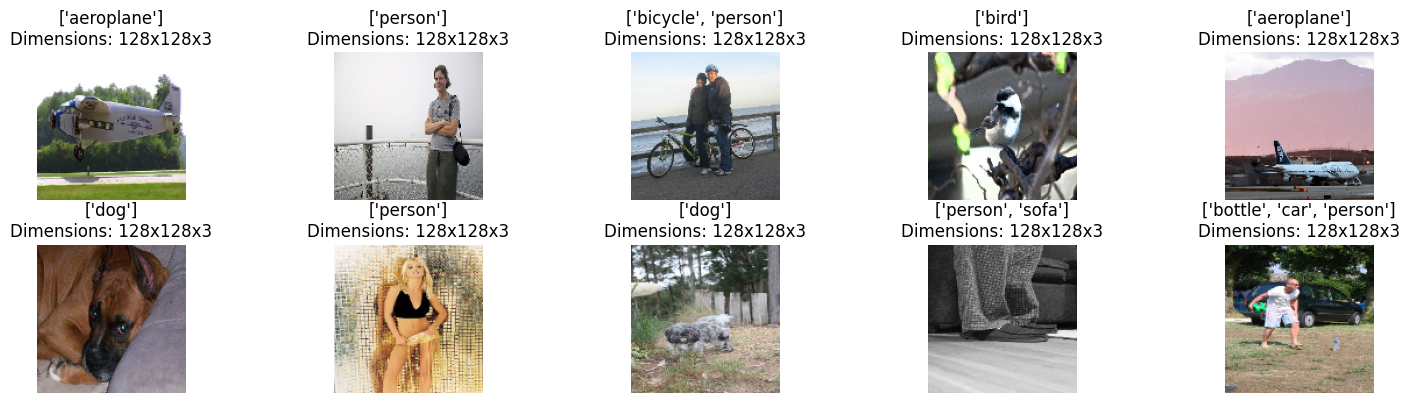

In [20]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(train_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in train_labels[random_indices]]
images = [i for i in train_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

### Validation set

In [21]:
validation_data = np.load(VALIDATION_PATH, allow_pickle=True)
validation_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/validation.npz' with keys: images, labels

In [22]:
validation_images = validation_data['images']
validation_images.shape

(1154, 227, 227, 3)

In [23]:
print(f'Size of validation images before preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [24]:
validation_images = preprocess_images(validation_images)
validation_images.shape

(1154, 128, 128, 3)

In [25]:
print(f'Size of validation images after preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images after preprocessing: 0.21130387485027313 GB


Labels encoding:

In [26]:
validation_labels = validation_data['labels']
validation_labels.shape

(1154,)

In [27]:
encoded_validation_labels = np.array([vector_encoding(l, N_CLASSES) for l in validation_labels])
encoded_validation_labels.shape, encoded_validation_labels[0], validation_labels[0]

((1154, 20),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 ['boat'])

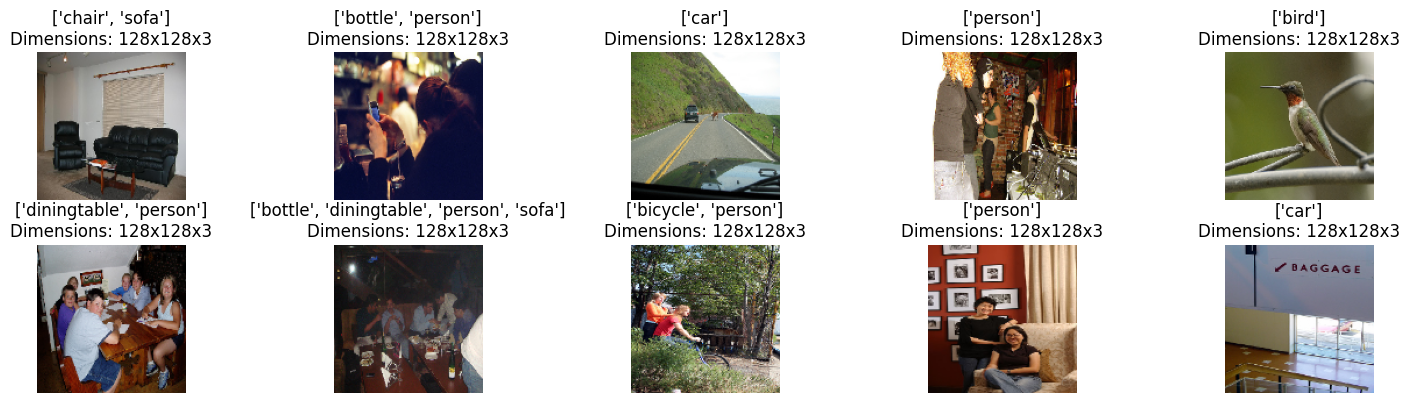

In [28]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(validation_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in validation_labels[random_indices]]
images = [i for i in validation_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

### Test set

In [29]:
test_data = np.load(TEST_PATH, allow_pickle=True)
test_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/test.npz' with keys: images, labels

In [30]:
test_images = test_data['images']
test_images.shape

(1154, 227, 227, 3)

In [31]:
print(f'Size of test images before preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [32]:
test_images = preprocess_images(test_images)
test_images.shape

(1154, 128, 128, 3)

In [33]:
print(f'Size of test images after preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images after preprocessing: 0.21130387485027313 GB


Labels encoding:

In [34]:
test_labels = test_data['labels']
test_labels.shape

(1154,)

In [35]:
encoded_test_labels = np.array([vector_encoding(l, N_CLASSES) for l in test_labels])
encoded_test_labels.shape, encoded_test_labels[0], test_labels[0]

((1154, 20),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1.]),
 ['bottle', 'person', 'tvmonitor'])

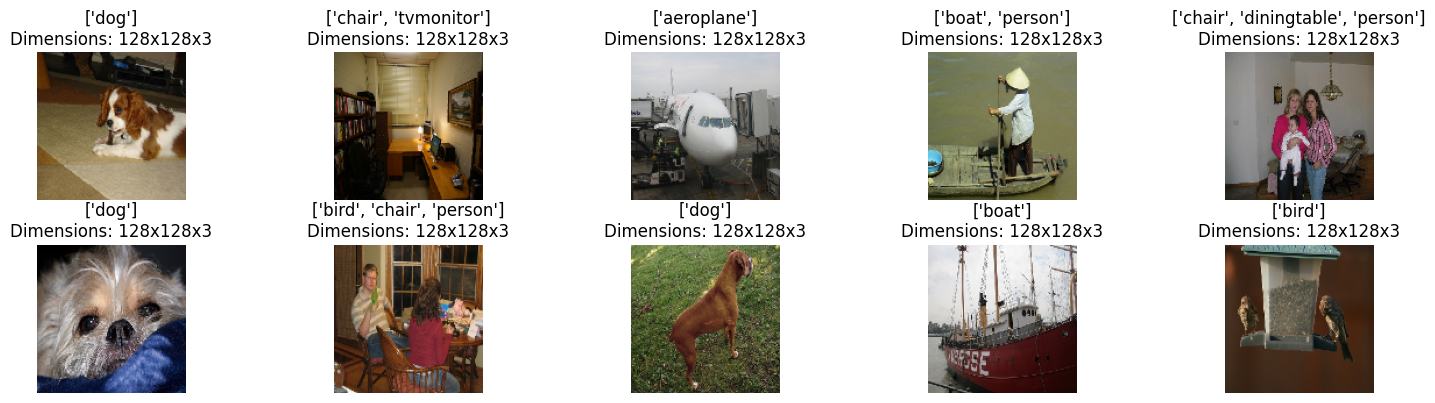

In [36]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(test_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in test_labels[random_indices]]
images = [i for i in test_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## Models

### Base model

In [ ]:
from tensorflow.keras.metrics import AUC

def create_base_model(input_shape=(64, 64, 3), num_classes=N_CLASSES, dropout_rate=0.3, model_name="baseline_model", load_model=False):
    if load_model:
        return load_model(f"{model_name}.keras")

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dropout(0.2),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(32, activation='relu', kernel_initializer="HeNormal"),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='sigmoid')
    ], name=model_name)

    # Mean Average Precision (mAP) usando AUC con curva Precision-Recall
    map_metric = AUC(
        curve='PR',  # Precision-Recall curve
        multi_label=True,
        name='mAP'
    )

    # Top-3 Accuracy
    top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
        k=3,
        name='top_3_accuracy'
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            top_3_accuracy,
            map_metric
        ]
    )

    return model

model = create_base_model(input_shape=(64, 64, 3))
model.summary()

Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)                  │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 60, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 60, 60, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 26, 26, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 233,044 (910.33 KB)

 Trainable params: 232,404 (907.83 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
print(f'Size of model: {asizeof.asizeof(model) / (1024**2)} MB')

Size of model: 0.5177764892578125 MB


In [ ]:
BATCH_SIZE = 64

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
early_stopping

In [ ]:
history = model.fit(
    train_images,
    encoded_train_labels,
    validation_data=(validation_images, encoded_validation_labels),
    batch_size=BATCH_SIZE,
    epochs=500,
    callbacks=[early_stopping],
)

Epoch 1/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2840 - loss: 0.1779 - mAP: 0.3050 - top_3_accuracy: 0.6169 - val_accuracy: 0.2166 - val_loss: 0.2418 - val_mAP: 0.2127 - val_top_3_accuracy: 0.4913
Epoch 2/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2785 - loss: 0.1790 - mAP: 0.2986 - top_3_accuracy: 0.6124 - val_accuracy: 0.2210 - val_loss: 0.2360 - val_mAP: 0.2131 - val_top_3_accuracy: 0.4991
Epoch 3/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2743 - loss: 0.1787 - mAP: 0.3048 - top_3_accuracy: 0.6163 - val_accuracy: 0.2305 - val_loss: 0.2246 - val_mAP: 0.2260 - val_top_3_accuracy: 0.5130
Epoch 4/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2742 - loss: 0.1789 - mAP: 0.3010 - top_3_accuracy: 0.6121 - val_accuracy: 0.2288 - val_loss: 0.2363 - val_mAP: 0.2243 - val_top_3_accuracy: 0.5043
Epoch 5/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2862 - loss: 0.1779 - mAP: 0.3039 - top_3_accuracy: 0.6135 - val_acc

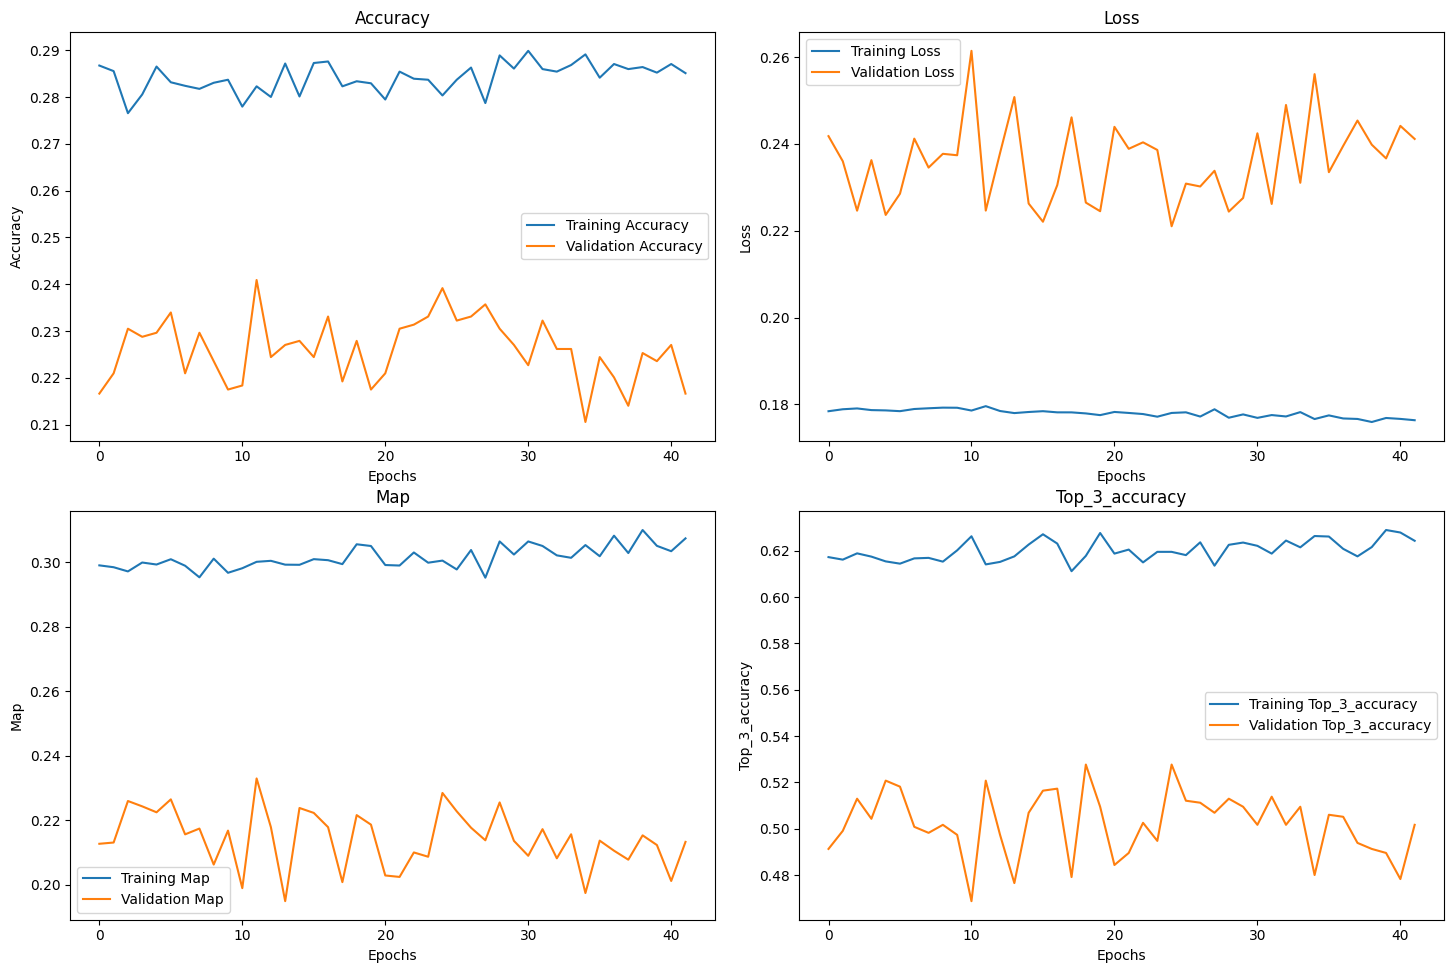

In [ ]:
plot_history(history)

#### Test

In [ ]:
y_pred = model.predict(test_images)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
accuracy.update_state(encoded_test_labels, y_pred)

accuracy.result().numpy()

0.22443675

In [ ]:
top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
top_3_accuracy.update_state(encoded_test_labels, y_pred)

top_3_accuracy.result().numpy()

0.5268631

In [ ]:
map_metric = tf.keras.metrics.AUC(
    curve='PR',
    multi_label=True
)

map_metric.update_state(encoded_test_labels, y_pred)
map_metric.result().numpy()

0.2359672

In [ ]:
metrics = {
    'Accuracy': accuracy.result().numpy(),
    'Top-3 Accuracy': top_3_accuracy.result().numpy(),
    'mAP': map_metric.result().numpy()
}

metrics

{'Accuracy': 0.22443675, 'Top-3 Accuracy': 0.5268631, 'mAP': 0.2359672}

In [ ]:
model.save(f"{model.name}.keras")

### Data augmentated model

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=25,           # Rotazione casuale fino a ±25 gradi
    width_shift_range=0.2,       # Traslazione orizzontale fino al 20% della larghezza
    height_shift_range=0.2,      # Traslazione verticale fino al 20% dell'altezza
    shear_range=0.25,            # Trasformazione prospettica (shear) fino al 25%
    zoom_range=[0.8, 1.2],       # Zoom casuale tra il 80% e il 120%
    channel_shift_range = 0.3,   # Variazione di intensità dei colori fino al 30%
    preprocessing_function=lambda x: np.fliplr(x) if np.random.random() < 0.3 else x,   # Flip orizzontale con probabilità del 30%
    fill_mode='nearest'          # Riempimento dei pixel mancanti
)

train_datagen.fit(train_images)

BATCH_SIZE = 64

# Crea un generatore per i dati di training
train_generator = train_datagen.flow(
    train_images,
    encoded_train_labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
train_generator

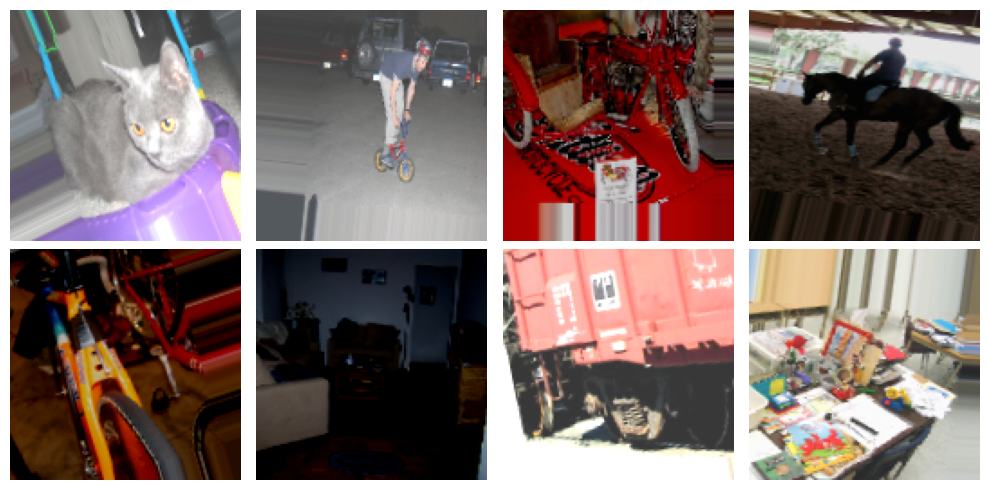

In [38]:
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    for x, y in train_generator:
        plt.imshow(x[0])
        plt.axis('off')
        break

plt.tight_layout()
plt.show()

In [146]:
from tensorflow.keras.metrics import AUC

def create_augmented_model(input_shape=(128, 128, 3), num_classes=N_CLASSES, dropout_rate=0.3, model_name="baseline_augmented_model", load_model=False):
    if load_model:
        return tf.keras.models.load_model(f"{model_name}.keras")

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dropout(0.2),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(128, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_initializer="HeNormal"),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='sigmoid')
    ], name=model_name)

    # Mean Average Precision (mAP) usando AUC con curva Precision-Recall
    map_metric = AUC(
        curve='PR',  # Precision-Recall curve
        multi_label=True,
        name='mAP'
    )

    # Top-3 Accuracy
    top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
        k=3,
        name='top_3_accuracy'
    )

    model.compile(
        optimizer=Adam(learning_rate=0.002),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            top_3_accuracy,
            map_metric
        ]
    )

    return model

model = create_augmented_model(input_shape=(128, 128, 3), load_model=True)
model.summary()

Model: "baseline_augmented_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_43 (Dropout)                 │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 58, 58, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 58, 58, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 26, 26, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,011,198 (3.86 MB)

 Trainable params: 336,788 (1.28 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 673,578 (2.57 MB)

In [40]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
early_stopping

In [43]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='baseline_augmented_model_epoch_{epoch:02d}.keras',
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True
    )

In [44]:
history = model.fit(
    train_generator,
    validation_data=(validation_images, encoded_validation_labels),
    epochs=500,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


145/145 ━━━━━━━━━━━━━━━━━━━━ 85s 431ms/step - accuracy: 0.2690 - loss: 0.1901 - mAP: 0.2848 - top_3_accuracy: 0.5735 - val_accuracy: 0.2340 - val_loss: 0.1926 - val_mAP: 0.2958 - val_top_3_accuracy: 0.5589
Epoch 2/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 274ms/step - accuracy: 0.2780 - loss: 0.1902 - mAP: 0.2891 - top_3_accuracy: 0.5857 - val_accuracy: 0.2106 - val_loss: 0.1947 - val_mAP: 0.2874 - val_top_3_accuracy: 0.5572
Epoch 3/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 276ms/step - accuracy: 0.2696 - loss: 0.1913 - mAP: 0.2887 - top_3_accuracy: 0.5821 - val_accuracy: 0.2591 - val_loss: 0.1920 - val_mAP: 0.2977 - val_top_3_accuracy: 0.5693
Epoch 4/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 83s 281ms/step - accuracy: 0.2685 - loss: 0.1911 - mAP: 0.2792 - top_3_accuracy: 0.5927 - val_accuracy: 0.2556 - val_loss: 0.1925 - val_mAP: 0.2902 - val_top_3_accuracy: 0.5737
Epoch 5/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - accuracy: 0.2695 - loss: 0.1918 - mAP: 0.2864 - top_3_accuracy: 0.5806 - val_accur

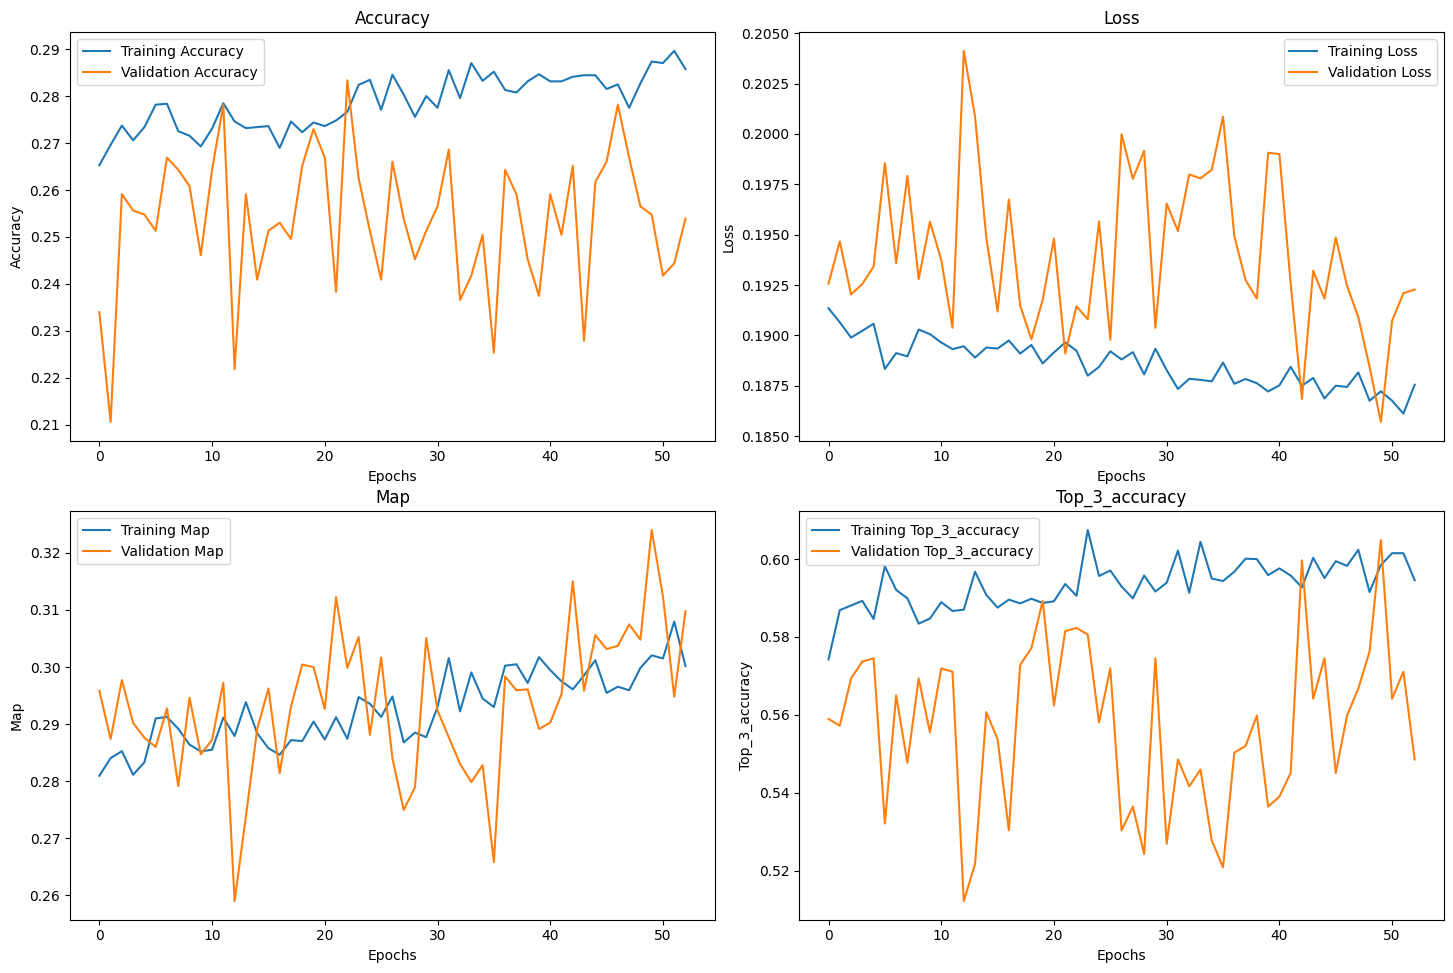

In [45]:
plot_history(history)

#### Test

In [150]:
y_pred = model.predict(test_images)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [151]:
accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
accuracy.update_state(encoded_test_labels, y_pred)

accuracy.result().numpy()

0.28509533

In [152]:
top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
top_3_accuracy.update_state(encoded_test_labels, y_pred)

top_3_accuracy.result().numpy()

0.57885617

In [153]:
map_metric = tf.keras.metrics.AUC(
    curve='PR',
    multi_label=True
)

map_metric.update_state(encoded_test_labels, y_pred)
map_metric.result().numpy()

0.3300751

In [154]:
metrics = {
    'Accuracy': accuracy.result().numpy(),
    'Top-3 Accuracy': top_3_accuracy.result().numpy(),
    'mAP': map_metric.result().numpy()
}

metrics

{'Accuracy': 0.28509533, 'Top-3 Accuracy': 0.57885617, 'mAP': 0.3300751}

In [56]:
model.save(f"{model.name}.keras")

array([[[ 91, 105, 106],
        [ 98, 113, 112],
        [119, 134, 133],
        ...,
        [ 76,  72,  71],
        [ 73,  69,  66],
        [ 64,  60,  59]],

       [[110, 122, 122],
        [106, 120, 120],
        [110, 125, 125],
        ...,
        [ 57,  52,  49],
        [ 67,  63,  62],
        [ 83,  79,  81]],

       [[121, 131, 130],
        [114, 129, 124],
        [121, 132, 128],
        ...,
        [ 71,  66,  62],
        [ 74,  69,  66],
        [ 75,  71,  68]],

       ...,

       [[ 99, 104, 100],
        [101, 107, 103],
        [ 90,  96,  92],
        ...,
        [107, 112, 105],
        [112, 118, 108],
        [114, 122, 112]],

       [[102, 108, 104],
        [ 89,  95,  91],
        [ 99, 105, 101],
        ...,
        [133, 140, 133],
        [110, 117, 109],
        [122, 129, 121]],

       [[ 86,  92,  90],
        [ 89,  95,  91],
        [ 94, 100,  96],
        ...,
        [113, 118, 114],
        [112, 119, 112],
        [119, 126, 119]]], dtype=uint8)
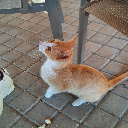

In [57]:
import os
import numpy as np
import cv2

immagini = []

for img in os.listdir("test"):
    img_path = os.path.join("test", img)

    try:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        immagini.append(img)

    except Exception as e:
        print(f"Errore nel caricare {img_path}: {e}")

immagini[0]

In [58]:
np.array(immagini).shape

(13, 128, 128, 3)

(-0.5, 127.5, 127.5, -0.5)

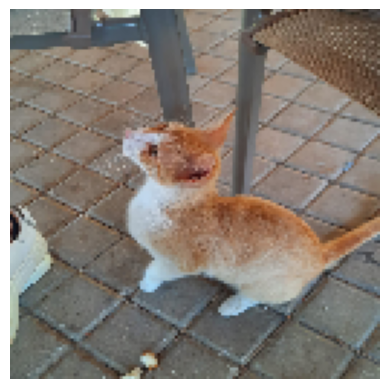

In [59]:
images = preprocess_images(np.array(immagini, dtype=float))
plt.imshow(images[0])
plt.axis('off')

In [137]:
predicted_classes_encoded = model.predict(images)
predicted_classes_encoded

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


array([[3.47662787e-03, 7.27037946e-03, 5.35868481e-02, 5.90050127e-03,
        6.78740665e-02, 3.47121531e-04, 1.31375454e-02, 1.78371817e-01,
        1.31441548e-01, 6.85157347e-03, 4.35375199e-02, 1.54573187e-01,
        9.23249312e-03, 2.67948676e-03, 2.41450042e-01, 4.92670573e-02,
        8.36607255e-03, 8.23565051e-02, 3.86737706e-03, 6.06700070e-02],
       [8.88504786e-04, 6.05406612e-03, 2.57738084e-01, 3.85173177e-03,
        6.31553447e-03, 2.02822885e-05, 6.31487323e-03, 8.08560178e-02,
        5.38428966e-03, 7.97245502e-02, 5.18391433e-04, 2.18367949e-01,
        4.93803732e-02, 1.12142798e-03, 6.90082684e-02, 2.66791857e-03,
        1.52177691e-01, 1.65908062e-03, 2.75597186e-03, 2.60364584e-04],
       [1.47969760e-02, 1.65046304e-02, 7.42463320e-02, 1.57833025e-02,
        6.04195930e-02, 3.71650024e-03, 4.96859513e-02, 2.17627347e-01,
        9.91663411e-02, 1.78122297e-02, 3.12367063e-02, 1.94790691e-01,
        2.18661688e-02, 1.11415237e-02, 2.22327098e-01, 3.9620

In [138]:
predicted_classes = [[CLASSES[i] for i, pred in enumerate(preds) if pred > 0.25] for preds in predicted_classes_encoded]
predicted_classes

[[],
 ['bird'],
 [],
 [],
 ['cat', 'dog'],
 [],
 [],
 ['person'],
 ['car', 'person'],
 ['person'],
 ['cat'],
 ['car', 'person'],
 ['person']]

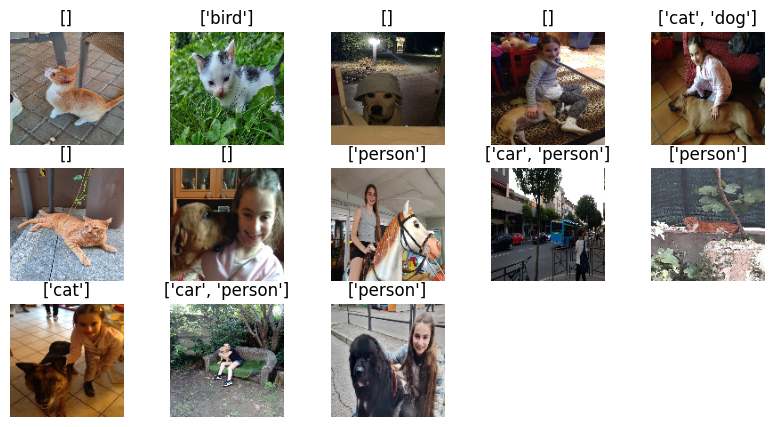

In [139]:
plt.figure(figsize=(10, 5))
for i in range(13):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.title(predicted_classes[i])
    plt.axis('off')

### Fine tuning with validation and test set
Actually not implemented

In [123]:
val_test_images = np.concatenate((validation_images, test_images), axis=0)
val_test_images.shape

(2308, 128, 128, 3)

In [124]:
val_test_encoded_labels = np.concatenate((encoded_validation_labels, encoded_test_labels), axis=0)
val_test_encoded_labels.shape

(2308, 20)

In [149]:
model = create_augmented_model(load_model=True)
model.summary()

Model: "baseline_augmented_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_43 (Dropout)                 │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 58, 58, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 58, 58, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 26, 26, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,011,198 (3.86 MB)

 Trainable params: 336,788 (1.28 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 673,578 (2.57 MB)

In [126]:
history = model.fit(
    val_test_images,
    val_test_encoded_labels,
    batch_size=BATCH_SIZE,
    epochs=1
    )

37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 300ms/step - accuracy: 0.2948 - loss: 0.1844 - mAP: 0.3277 - top_3_accuracy: 0.6365


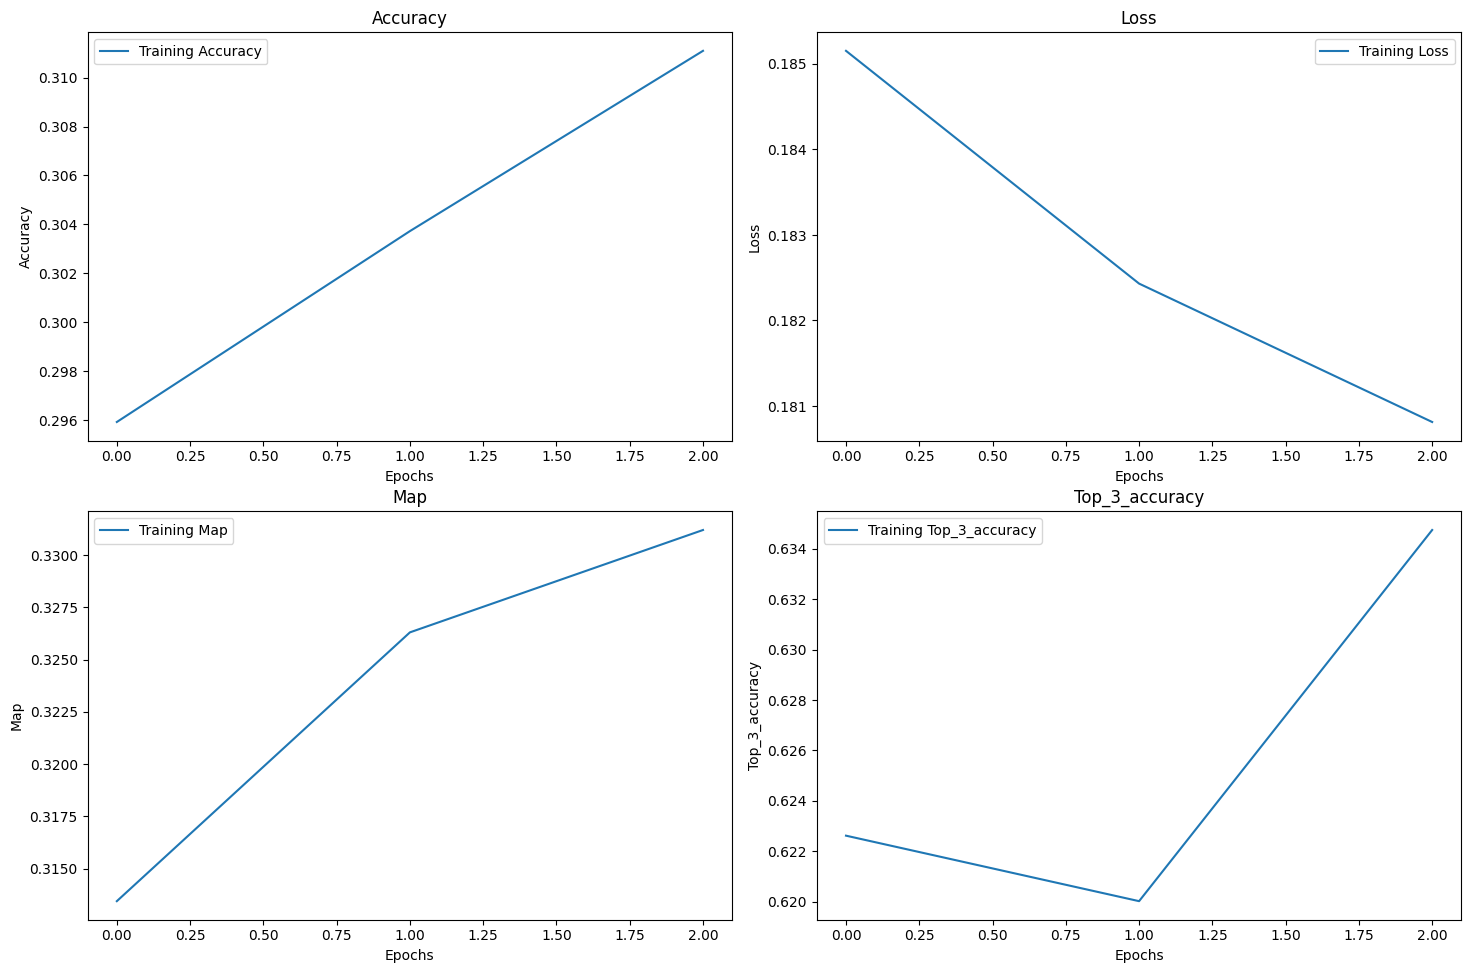

In [111]:
plot_history(history)

In [ ]:
model.save(f"{model.name}.keras")